#### Setup

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
sd = pd.read_csv('gdrive/My Drive/wholset/annotations.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FileNotFoundError: ignored

In [0]:
root='gdrive/My Drive/CAL/CAL-master/training/'
import os
os.chdir(root)

In [17]:
# standard imports 
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim
!pip install ipdb
from ipdb import set_trace

# jupyter setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

# own modules
from dataloader import CAL_Dataset
from net import get_model
from dataloader import get_data, get_mini_data
from train import fit, custom_loss, validate
from metrics import calc_metrics

# paths
data_path = 'gdrive/My Drive/wholset/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


uncomment the cell below if you want your experiments to yield always the same results

In [0]:
# manualSeed = 42

# np.random.seed(manualSeed)
# torch.manual_seed(manualSeed)

# # if you are using GPU
# torch.cuda.manual_seed(manualSeed)
# torch.cuda.manual_seed_all(manualSeed)

# torch.backends.cudnn.enabled = False 
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True

#### Training

Initialize the model. Possible Values for the task block type: MLP, LSTM, GRU, TempConv

In [13]:
params = {'name': 'test', 'type_': 'MLP', 'lr': 3e-4, 'n_h': 128, 'p':0.5, 'seq_len':1}
model, opt = get_model(params)

Weights getting loaded
Weights loaded


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [0]:
os.chdir('/content')

get the data loader. get mini data gets only a subset of the training data, on which we can try if the model is able to overfit

In [0]:
train_dl, valid_dl = get_data(data_path, model.params.seq_len, batch_size=16)
# train_dl, valid_dl = get_mini_data(data_path, model.params.seq_len, batch_size=16, l=4000)

uncomment the next cell if the feature extractor should also be trained

In [0]:
# for name,param in model.named_parameters():
#     param.requires_grad = True
# opt = optim.Adam(model.parameters())

Train the model. We automatically save the model with the lowest val_loss. If you want to continue the training and keep the loss history, just pass it as an additional argument as shown below.

In [0]:
#!export CUDA_LAUNCH_BLOCKING = 1;

In [26]:
model, val_hist = fit(10, model, custom_loss, opt, train_dl, valid_dl)

100%|██████████| 2/2 [00:12<00:00,  7.87s/it]

0.12516672536730766


FileNotFoundError: ignored

In [0]:
# model, val_hist = fit(1, model, custom_loss, opt, train_dl, valid_dl, val_hist=val_hist)

In [0]:
val_hist

[0.13320919126272202,
 0.12733575701713562,
 0.1334841623902321,
 0.13966603204607964,
 0.14335506781935692,
 0.13123629987239838,
 0.1312980130314827,
 0.13996009156107903,
 0.13251464068889618,
 0.13049820810556412]

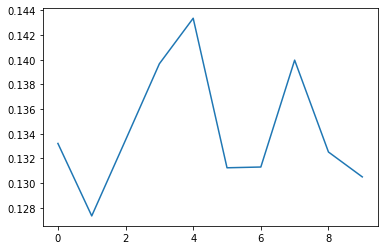

In [0]:
plt.plot(val_hist)

#### evalute the model

In [0]:
model, _ = get_model(params)
model.load_state_dict(torch.load(f"./models/{model.params.name}.pth"))
model.eval().to(device);

Weights getting loaded
Weights loaded


In [0]:
model.eval();
_, all_preds, all_labels = validate(model, valid_dl, custom_loss)

100%|██████████| 2/2 [00:04<00:00,  2.95s/it]

0.12733575701713562


In [0]:
calc_metrics(all_preds, all_labels)

/home/vasu/Desktop/project/CAL-master/training/metrics.py:33: RuntimeWarning: invalid value encountered in long_scalars
  r1 = 100*(cm[i,i]/(np.sum(cm[i,:])))


{'red_light_val_acc': 13.953488372093023,
 'red_light_IoU': 7.268170426065162,
 'hazard_stop_val_acc': 62.7906976744186,
 'hazard_stop_IoU': 39.48717948717949,
 'speed_sign_val_acc': 60.46511627906977,
 'speed_sign_IoU': 15.11627906976744,
 'relative_angle_MAE_mean': 0.19999176,
 'center_distance_MAE_mean': 0.6939773,
 'veh_distance_MAE_mean': 0.5023928}

#### plot results

In [0]:
# for convience, we can pass an integer instead of the full string
int2key = {0: 'red_light', 1:'hazard_stop', 2:'speed_sign', 
           3:'relative_angle', 4: 'center_distance', 5: 'veh_distance'}

In [0]:
def plot_preds(k, all_preds, all_labels, start=0, delta=1000):
    if isinstance(k, int): k = int2key[k]
    
    # get preds and labels
    class_labels = ['red_light', 'hazard_stop', 'speed_sign']
    pred = np.argmax(all_preds[k], axis=1) if k in class_labels else all_preds[k]
    label = all_labels[k][:, 1] if k in class_labels else all_labels[k]
    
    plt.plot(pred[start:start+delta], 'r--', label='Prediction', linewidth=2.0)
    plt.plot(label[start:start+delta], 'g', label='Ground Truth', linewidth=2.0)
    
    plt.legend()
    plt.grid()
    plt.show()

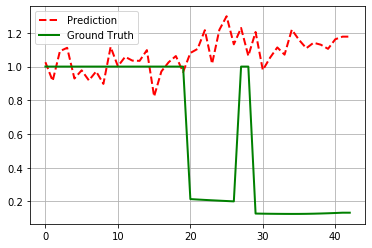

In [0]:
plot_preds(5, all_preds, all_labels, start=0, delta=4000)

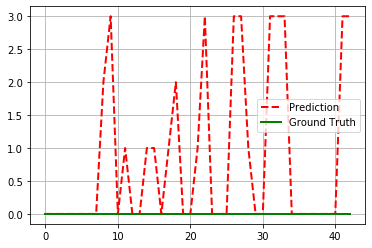

In [0]:
plot_preds(2, all_preds, all_labels, start=0, delta=4000)